# More optimisation investigations
Created 09/10/2025

Objectives:
* Found that [solutions are not converging as well as we would like...](extract_phases.ipynb).
    * Explore 2 site optimisaton.
    * Explore gradient based optimisation.

# Package imports

In [1]:
import sys

In [2]:
sys.path.append("../../../")

In [3]:
from itertools import chain
import re

In [4]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os
import pickle

In [98]:
import numpy as np
import pandas as pd
import jax.numpy as jnp

import matplotlib.pyplot as plt

In [6]:
import quimb as qu
import quimb.tensor as qtn
from quimb.tensor.optimize import TNOptimizer

/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:54: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:36: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:73: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(


In [7]:
from SPTOptimization.SymmetryActionWithBoundaryUnitaries import SymmetryActionWithBoundaryUnitaries

from SPTOptimization.utils import (
    to_npc_array,
    get_right_identity_environment,
    get_right_identity_environment_from_tp_tensor,
    multiply_stacked_unitaries_against_mps,
    inner_product_b_tensors,
    get_npc_identity_operator
)

from SPTOptimization.Optimizers.MPSBrickSolver import(
    MPSBrickSolver
)

# Load data

In [8]:
DATA_DIR = r"../../../data/interpolated_nontrivial_fermionic_proj_rep_to_nontrivial_proj_rep_200_site_dmrg/"

In [9]:
def parse_file_name(file_name):
    interpolation = int(file_name.split('_')[0])/100

    return interpolation

In [10]:
loaded_data = dict()
energies = dict()

for local_file_name in list(os.walk(DATA_DIR))[0][2]:
    f_name = r"{}/{}".format(DATA_DIR, local_file_name, ignore_unknown=False)

    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)

        data_info = parse_file_name(local_file_name)
        loaded_data[data_info]=data['wavefunction']
        energies[data_info]=data['energy']

In [11]:
psi = loaded_data[0.45]

# Definitions

In [12]:
MAX_VIRTUAL_BOND_DIM = 30
MAX_INTERMEDIATE_VIRTUAL_BOND_DIM = 2*MAX_VIRTUAL_BOND_DIM
# MPO bond dim?
MAX_MPO_BOND_DIM = 50

SVD_CUTOFF = 1e-3

Define bosonic symmetries. Label by the group element added.

In [13]:
np_00 = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

np_01 = np.array([
    [0, 1, 0, 0],
    [1, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
])

np_10 = np.array([
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])

np_11 = np.array([
    [0, 0, 0, 1],
    [0, 0, 1, 0],
    [0, 1, 0, 0],
    [1, 0, 0, 0]
])

In [14]:
bosonic_np_symmetries = [
    np_00,
    np_01,
    np_10,
    np_11
]

In [15]:
bosonic_npc_symmetries = [
    to_npc_array(X) for X in bosonic_np_symmetries
]

In [16]:
npc_00 = to_npc_array(np_00)
npc_01 = to_npc_array(np_01)
npc_10 = to_npc_array(np_10)
npc_11 = to_npc_array(np_11)

Define "fermionic symmetries". Just identity and JW string.

In [17]:
np_I = np.array([
    [1, 0],
    [0, 1]
])

np_JW = np.array([
    [1, 0],
    [0, -1]
])

In [18]:
fermionic_np_symmetries = [np_I, np_JW]

In [19]:
fermionic_npc_symmetries = [
    to_npc_array(X) for X in fermionic_np_symmetries
]

In [20]:
npc_JW = fermionic_npc_symmetries[1]

In [21]:
symmetry_actions = [
    [[b, f] for b in bosonic_np_symmetries]
    for f in fermionic_np_symmetries
]

In [22]:
shifted_symmetry_actions = [
    [[f, b] for b in bosonic_np_symmetries]
    for f in fermionic_np_symmetries
]

In [23]:
case = SymmetryActionWithBoundaryUnitaries(
    psi,
    symmetry_actions[1][1]*40,
    left_symmetry_index=60,
    left_boundary_unitaries=[np_I, np_00]*1,
    right_boundary_unitaries=[np_00, np_I]*1
)

In [24]:
case.compute_svd_approximate_expectation()

(0.16743974334678505+2.9985820854768057e-18j)

In [59]:
def generate_problem_rdm(quimb_psi, symmetry_site_pairs, leftmost_symmetry_site,
                         num_symmetry_sites, num_boundary_sites):
    q_top = quimb_psi.copy(deep=True)
    for i, s in symmetry_site_pairs:
        q_top.gate(
            s,
            where=i,
            contract=False,
            inplace=True
        )
    
    indices_to_map = list(chain(
        range(leftmost_symmetry_site-num_boundary_sites, leftmost_symmetry_site),
        range(leftmost_symmetry_site+num_symmetry_sites, leftmost_symmetry_site+num_symmetry_sites+num_boundary_sites)
    ))

    index_mapping = {f'k{i}': f'b{i}' for i in indices_to_map}

    q_bottom = (
        quimb_psi
        .copy()
        .reindex(index_mapping, inplace=True)
        .conj()
    )

    sites_to_contract = {
        'left': list(range(leftmost_symmetry_site-num_boundary_sites)),
        'middle': list(range(leftmost_symmetry_site, leftmost_symmetry_site+num_symmetry_sites)),
        'right': list(range(leftmost_symmetry_site+num_symmetry_sites+num_boundary_sites, quimb_psi.L))
    }

    tags_to_contract = {
        k: [f'I{i}' for i in v]
        for k, v in sites_to_contract.items()
    }

    tn = (q_top & q_bottom)

    tnc = (
        tn
        .contract(tags_to_contract['left'])
        .contract(tags_to_contract['middle'])
        .contract(tags_to_contract['right'])
    )

    # Expand the d=4 qudit sites into 2 qubits.
    even_left_sites = [
        i for i in range(leftmost_symmetry_site - num_boundary_sites, leftmost_symmetry_site)
        if (i % 2 == 0)
    ]

    even_right_sites = [
        i for i in range(
            leftmost_symmetry_site + num_symmetry_sites,
            leftmost_symmetry_site+num_symmetry_sites+num_boundary_sites
        )
        if (i % 2 == 0)
    ]

    for s in ['k', 'b']:
        left_sites = [even_left_sites[0], even_right_sites[0]]
        for i in left_sites:

            t = tnc.tensor_map[list(tnc.ind_map[f'{s}{i}'])[0]]
            tr = tnc.tensor_map[list(tnc.ind_map[f'{s}{i+1}'])[0]]
            vr = [
                ind for ind in t.inds if ind in tr.inds
            ][0]
            vl = [
                ind for ind in t.inds
                if ind not in [vr, f'{s}{i}']
            ]
        
            t.unfuse(
                {f'{s}{i}': [f'{s}{i}-0', f'{s}{i}-1']},
                {f'{s}{i}': [2, 2]},
                inplace=True
            )

            #t.split([f'{s}{i}-0', vl])

        right_sites = [even_left_sites[-1], even_right_sites[-1]]
        right_sites = [s for s in right_sites if s not in left_sites]
        for i in right_sites:

            t = tnc.tensor_map[list(tnc.ind_map[f'{s}{i}'])[0]]
            tl = tnc.tensor_map[list(tnc.ind_map[f'{s}{i-1}'])[0]]
            vl = [
                ind for ind in t.inds if ind in tl.inds
            ][0]
        
            t.unfuse(
                {f'{s}{i}': [f'{s}{i}-0', f'{s}{i}-1']},
                {f'{s}{i}': [2, 2]},
                inplace=True
            )

            #t.split([f'{s}{i}-0', vl])

        inner_sites = [
            s for s in even_left_sites + even_right_sites
            if s not in left_sites + right_sites
        ]

        """
        inner_sites = [
            *even_left_sites[1:-1],
            *even_right_sites[1:-1]
        ]
        """

        for i in inner_sites:

            t = tnc.tensor_map[list(tnc.ind_map[f'{s}{i}'])[0]]
            tl = tnc.tensor_map[list(tnc.ind_map[f'{s}{i-1}'])[0]]
            vl = [
                ind for ind in t.inds
                if ind not in [vr, f'{s}{i}']
            ]
        
            t.unfuse(
                {f'{s}{i}': [f'{s}{i}-0', f'{s}{i}-1']},
                {f'{s}{i}': [2, 2]},
                inplace=True
            )

            #t.split([f'{s}{i}-0', vl])
        
    return tnc

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


## Optimisation functions

In [26]:
def loss(circ_pair, problem_rdm):
    c = (problem_rdm & circ_pair)^...

    c_abs_squared = (
        c
        *jnp.conjugate(c)
    )
    c_abs_squared = jnp.real(c_abs_squared)

    out = 1-c_abs_squared

    return out

## Gate functions

In [27]:
def single_qubit_layer(circ, gate_round=None):
    """Apply a parametrizable layer of single qubit ``U3`` gates.
    """
    for i in range(circ.N):
        # initialize with random parameters
        params = qu.randn(3, dist='uniform')
        circ.apply_gate(
            'U3',
            *params,
            i,
            gate_round=gate_round,
            parametrize=True
        )

In [28]:
def two_qubit_layer(circ, gate2='CZ', start=0, gate_round=None):
    """Apply a layer of constant entangling gates.
    """
    num_sites = circ.N # Assuming this is even
    sites = [
        i % num_sites
        for i in range(start, start + num_sites)
    ]
    
    site_pairs = list(zip(sites[::2], sites[1::2]))

    for i, j in site_pairs:
        circ.apply_gate(
            gate2,
            i,
            j,
            gate_round=gate_round
        )

    if (num_sites % 2) == 1:
        circ.apply_gate(
            gate2,
            sites[0],
            sites[-1],
            gate_round=gate_round
        )

In [29]:
def ansatz_circuit(n, depth, first_site=0, gate2='CZ', gate_tag=None,
                   **kwargs):
    """Construct a circuit of single qubit and entangling layers.
    """
    circ = qtn.Circuit(n, **kwargs)

    for r in range(depth):
        # single qubit gate layer
        single_qubit_layer(circ, gate_round=r)

        # alternate between forward and backward CZ layers
        two_qubit_layer(
            circ, gate2=gate2, gate_round=r, start=r % 2)

    # add a final single qubit layer
    single_qubit_layer(circ, gate_round=r + 1)

    circ = circ.uni

    no_labels_index_map = dict()

    old_site = 0
    new_site = first_site

    while old_site < n:
        if (new_site % 2) == 0:
            no_labels_index_map[f'{old_site}'] = f'{new_site}-0'
            no_labels_index_map[f'{old_site+1}'] = f'{new_site}-1'
            old_site += 2
        else:
            no_labels_index_map[f'{old_site}'] = f'{new_site}'
            old_site += 1
        new_site += 1

    assert old_site == n
    
    if gate_tag is not None:
        for t in circ.tensors:
            t.add_tag(gate_tag)

    index_labels = ['k', 'b']

    # Include labels in map
    index_map = {
        f'{l}{k}': f'{l}{v}'
        for k, v in no_labels_index_map.items()
        for l in index_labels
    }

    circ.reindex(index_map, inplace=True)

    return circ

In [30]:
def ansatz_circuit_pair(leftmost_symmetry_site,
    num_symmetry_sites, num_boundary_sites, depth,
    gate2='CZ', **kwargs):
    """Construct a circuit of single qubit and entangling layers.
    """
    left_start_site = leftmost_symmetry_site-num_boundary_sites
    right_start_site = leftmost_symmetry_site+num_symmetry_sites

    left_num_expanded_boundary_sites = sum(
        2 if (i % 2 == 0) else 1
        for i in range(left_start_site, left_start_site + num_boundary_sites)
    )

    left_circuit = ansatz_circuit(
        left_num_expanded_boundary_sites,
        depth,
        first_site=left_start_site,
        gate2=gate2,
        gate_tag='left',
        **kwargs
    )

    right_num_expanded_boundary_sites = sum(
        2 if (i % 2 == 0) else 1
        for i in range(right_start_site, right_start_site + num_boundary_sites)
    )

    right_circuit = ansatz_circuit(
        right_num_expanded_boundary_sites,
        depth,
        first_site=right_start_site,
        gate2=gate2,
        gate_tag='right',
        **kwargs
    )

    circ_pair = (left_circuit & right_circuit)

    return circ_pair

In [31]:
def split_circ_pair(circ_pair):
    left_circuit = qtn.TensorNetwork(
        list(map(circ_pair.tensor_map.__getitem__, circ_pair.tag_map['left']))
    )

    right_circuit = qtn.TensorNetwork(
        list(map(circ_pair.tensor_map.__getitem__, circ_pair.tag_map['right']))
    )

    return (left_circuit, right_circuit)

# Initialize problem rdm

Try just 2 boundary sites, see what happens.

In [53]:
num_boundary_sites=2
left_most_symmetry_site=60
num_symmetry_sites=80

#total_physical_dim = 2**num_boundary_sites

In [54]:
mps_psi = psi

In [55]:
psi_arrays = list()
psi_arrays.append(mps_psi.get_B(0, 'Th')[0, ...].to_ndarray())
for i in range(1, mps_psi.L-1):
    psi_arrays.append(mps_psi.get_B(i).to_ndarray())
psi_arrays.append(mps_psi.get_B(mps_psi.L-1)[..., 0].to_ndarray())

q1 = (
    qtn
    .tensor_1d
    .MatrixProductState(psi_arrays, shape='lpr')
)

Pick this symmetry action for example.

In [56]:
len(symmetry_actions[0])

4

In [57]:
k2 = 1
symms = symmetry_actions[0][3]

In [60]:
symmetry_site_pairs = (
    [(i, symms[0]) for i in range(left_most_symmetry_site, left_most_symmetry_site+num_symmetry_sites, 2)]
    + [(i, symms[1]) for i in range(left_most_symmetry_site+1, left_most_symmetry_site+num_symmetry_sites+1, 2)]
)

problem_rdm = generate_problem_rdm(
    q1,
    symmetry_site_pairs,
    left_most_symmetry_site,
    num_symmetry_sites,
    num_boundary_sites
)

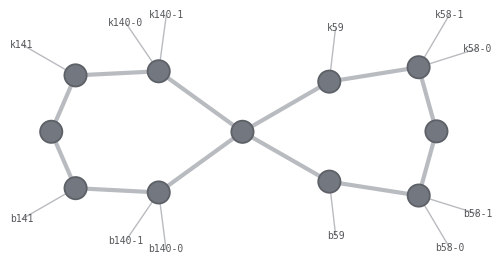

In [61]:
problem_rdm.draw()

In [62]:
n = 2
gate2 = 'CZ'

In [63]:
depth=6

In [64]:
circ_pair = ansatz_circuit_pair(
    left_most_symmetry_site,
    num_symmetry_sites,
    num_boundary_sites,
    depth,
    gate2
)

/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/circuit.py:2587: FutureWarning: In future the tensor network returned by ``circ.uni`` will not be transposed as it is currently, to match the expectation from ``U = circ.uni.to_dense()`` behaving like ``U @ psi``. You can retain this behaviour with ``circ.get_uni(transposed=True)``.
  warnings.warn(


In [65]:
cl, cr = split_circ_pair(circ_pair)

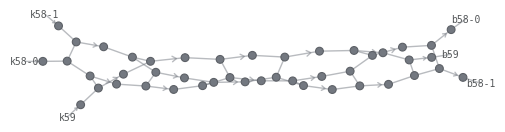

In [66]:
cl.draw()

# Find gate depth
Iterate over gate depth using a simple L-BFGS-B (gradient) solver.

In [67]:
num_iterations = 10

In [68]:
scores = list()

for _ in range(num_iterations):
    circ_pair = ansatz_circuit_pair(
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites,
        depth
    )
    
    tnopt = qtn.TNOptimizer(
        circ_pair,                        # the tensor network we want to optimize
        loss,                     # the function we want to minimize
        loss_constants={'problem_rdm': problem_rdm},  # supply U to the loss function as a constant TN
        tags=['U3'],              # only optimize U3 tensors
        #autodiff_backend='jax',   # use 'autograd' for non-compiled optimization
        optimizer='adam',     # the optimization algorithm
        progbar=False
    )
    
    circ_opt = tnopt.optimize(
        n=10000,
        jac=True,
        hessp=False
    )

    scores.append(tnopt.losses)

/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(


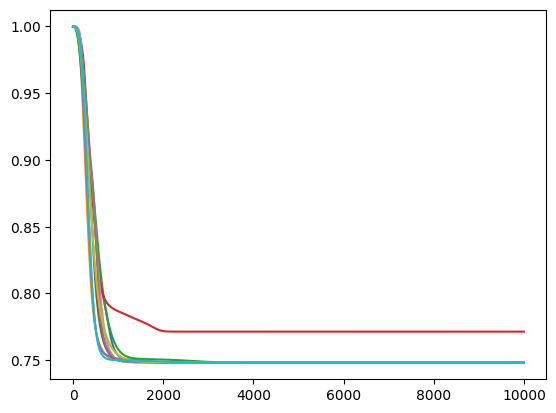

In [69]:
for l in scores:
    plt.plot(l)

In [70]:
scores = list()

for _ in range(50):
    circ_pair = ansatz_circuit_pair(
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites,
        depth
    )
    
    tnopt = qtn.TNOptimizer(
        circ_pair,                        # the tensor network we want to optimize
        loss,                     # the function we want to minimize
        loss_constants={'problem_rdm': problem_rdm},  # supply U to the loss function as a constant TN
        tags=['U3'],              # only optimize U3 tensors
        #autodiff_backend='jax',   # use 'autograd' for non-compiled optimization
        optimizer='adam',     # the optimization algorithm
        progbar=False
    )
    
    circ_opt = tnopt.optimize(
        n=4000,
        jac=True,
        hessp=False
    )

    scores.append(tnopt.losses)

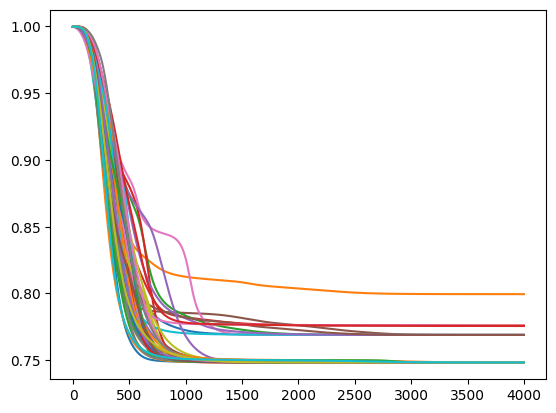

In [71]:
for l in scores:
    plt.plot(l)

Vary gate depth:

In [72]:
gate_depths = list(range(1, 12))

In [74]:
num_iterations_per_depth = 10

In [75]:
scores = list()

for depth in gate_depths:
    print(depth)
    scores.append(list())

    for _ in range(num_iterations_per_depth):
        circ_pair = ansatz_circuit_pair(
            left_most_symmetry_site,
            num_symmetry_sites,
            num_boundary_sites,
            depth
        )
        
        tnopt = qtn.TNOptimizer(
            circ_pair,                        # the tensor network we want to optimize
            loss,                     # the function we want to minimize
            loss_constants={'problem_rdm': problem_rdm},  # supply U to the loss function as a constant TN
            tags=['U3'],              # only optimize U3 tensors
            #autodiff_backend='jax',   # use 'autograd' for non-compiled optimization
            optimizer='adam',     # the optimization algorithm
            progbar=False
        )
        
        circ_opt = tnopt.optimize(
            n=2000,
            jac=True,
            hessp=False
        )

        scores[-1].append(tnopt.losses)

1
2
3
4
5
6
7
8
9
10
11


In [76]:
final_scores = np.array([[np.min(l1) for l1 in l] for l in scores])

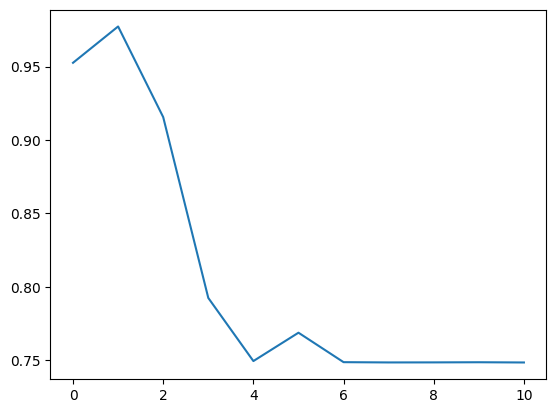

In [77]:
plt.plot(np.mean(final_scores, axis=1))

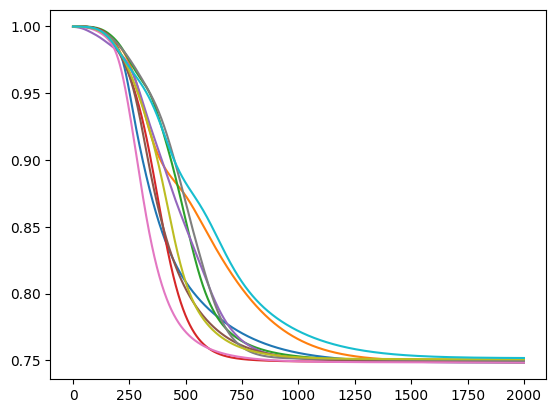

In [79]:
for l in scores[4]:
    plt.plot(l)

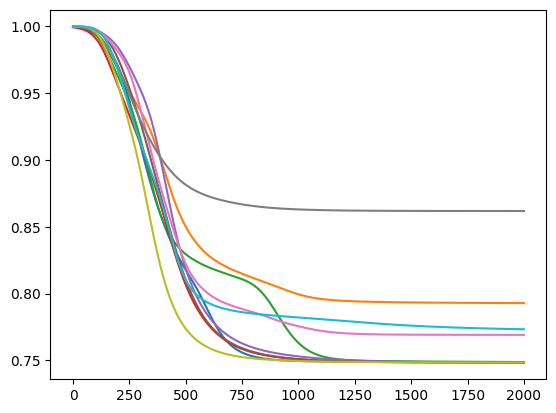

In [80]:
for l in scores[5]:
    plt.plot(l)

# Optimize methods

In [81]:
num_boundary_sites=2
left_most_symmetry_site=60
num_symmetry_sites=80

In [82]:
mps_psi = psi

In [83]:
psi_arrays = list()
psi_arrays.append(mps_psi.get_B(0, 'Th')[0, ...].to_ndarray())
for i in range(1, mps_psi.L-1):
    psi_arrays.append(mps_psi.get_B(i).to_ndarray())
psi_arrays.append(mps_psi.get_B(mps_psi.L-1)[..., 0].to_ndarray())

q1 = (
    qtn
    .tensor_1d
    .MatrixProductState(psi_arrays, shape='lpr')
)

In [84]:
problem_rdm = generate_problem_rdm(
    q1,
    symmetry_site_pairs,
    left_most_symmetry_site,
    num_symmetry_sites,
    num_boundary_sites
)

In [85]:
grad_free_methods = [
    'Nelder-Mead',
    'L-BFGS-B',
    'Powell',
    'CG',
    'BFGS',
    'TNC',
    'COBYLA',
    'SLSQP',
]

In [86]:
depth=5

In [87]:
num_iterations=20

In [88]:
scores=list()

for method in grad_free_methods:
    print(method)
    scores.append(list())

    for i in range(num_iterations):
        print('-> ' + str(i))

        circ_pair = ansatz_circuit_pair(
            left_most_symmetry_site,
            num_symmetry_sites,
            num_boundary_sites,
            depth
        )
        
        tnopt = qtn.TNOptimizer(
            circ_pair,                        # the tensor network we want to optimize
            loss,                     # the function we want to minimize
            loss_constants={'problem_rdm': problem_rdm},  # supply U to the loss function as a constant TN
            tags=['U3'],              # only optimize U3 tensors
            #autodiff_backend='jax',   # use 'autograd' for non-compiled optimization
            optimizer=method,     # the optimization algorithm
            progbar=False
        )
        
        circ_opt = tnopt.optimize(
            n=3000,
            jac=False,
            hessp=False
        )

        scores[-1].append(tnopt.losses)

Nelder-Mead
-> 0
-> 1
-> 2
-> 3
-> 4
-> 5
-> 6
-> 7
-> 8
-> 9
-> 10
-> 11
-> 12
-> 13
-> 14
-> 15
-> 16
-> 17
-> 18
-> 19
L-BFGS-B
-> 0
-> 1
-> 2
-> 3
-> 4
-> 5
-> 6
-> 7
-> 8
-> 9
-> 10
-> 11
-> 12
-> 13
-> 14
-> 15
-> 16
-> 17
-> 18
-> 19
Powell
-> 0
-> 1
-> 2
-> 3
-> 4
-> 5
-> 6
-> 7
-> 8
-> 9
-> 10
-> 11
-> 12
-> 13
-> 14
-> 15
-> 16
-> 17
-> 18
-> 19
CG
-> 0
-> 1
-> 2
-> 3
-> 4
-> 5
-> 6
-> 7
-> 8
-> 9
-> 10
-> 11
-> 12
-> 13
-> 14
-> 15
-> 16
-> 17
-> 18
-> 19
BFGS
-> 0
-> 1
-> 2
-> 3
-> 4
-> 5
-> 6
-> 7
-> 8
-> 9
-> 10
-> 11
-> 12
-> 13
-> 14
-> 15
-> 16
-> 17
-> 18
-> 19
TNC
-> 0


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:1523: OptimizeWarning: Unknown solver options: maxiter
  self.res = minimize(


-> 1
-> 2
-> 3
-> 4
-> 5
-> 6
-> 7
-> 8
-> 9
-> 10
-> 11
-> 12
-> 13
-> 14
-> 15
-> 16
-> 17
-> 18
-> 19
COBYLA
-> 0
-> 1
-> 2
-> 3
-> 4
-> 5
-> 6
-> 7
-> 8
-> 9
-> 10
-> 11
-> 12
-> 13
-> 14
-> 15
-> 16
-> 17
-> 18
-> 19
SLSQP
-> 0
-> 1
-> 2
-> 3
-> 4
-> 5
-> 6
-> 7
-> 8
-> 9
-> 10
-> 11
-> 12
-> 13
-> 14
-> 15
-> 16
-> 17
-> 18
-> 19


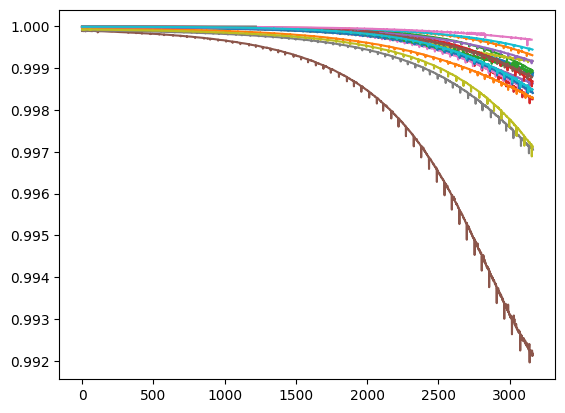

In [89]:
for l in scores[0]:
    plt.plot(l)

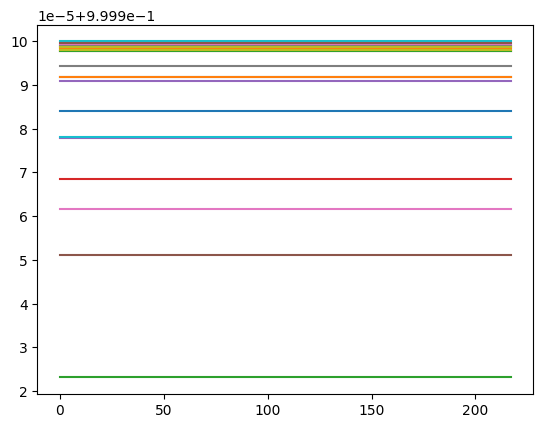

In [90]:
for l in scores[1]:
    plt.plot(l)

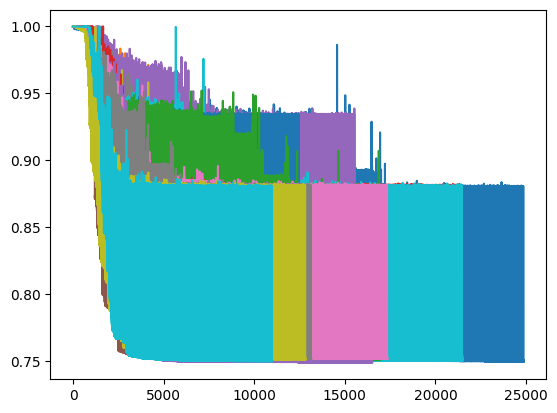

In [91]:
for l in scores[2]:
    plt.plot(l)

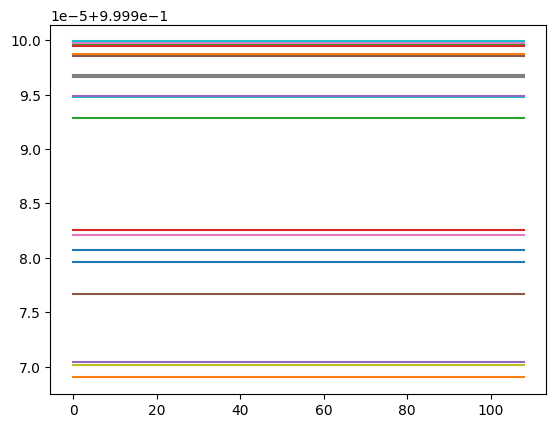

In [92]:
for l in scores[3]:
    plt.plot(l)

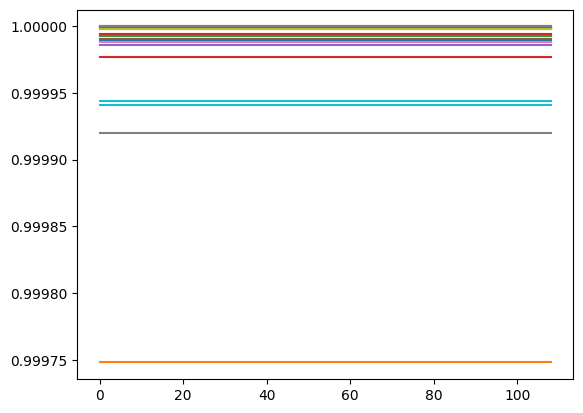

In [93]:
for l in scores[4]:
    plt.plot(l)

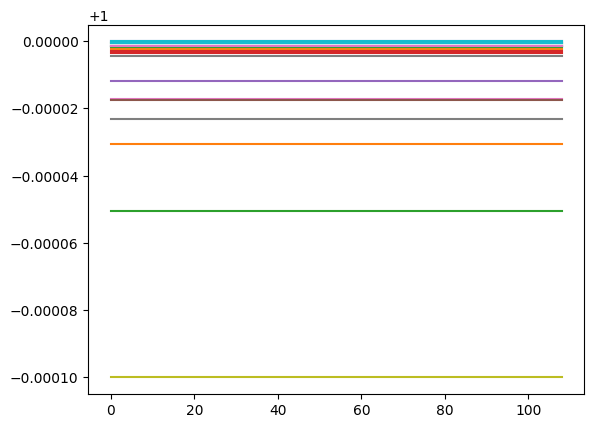

In [94]:
for l in scores[5]:
    plt.plot(l)

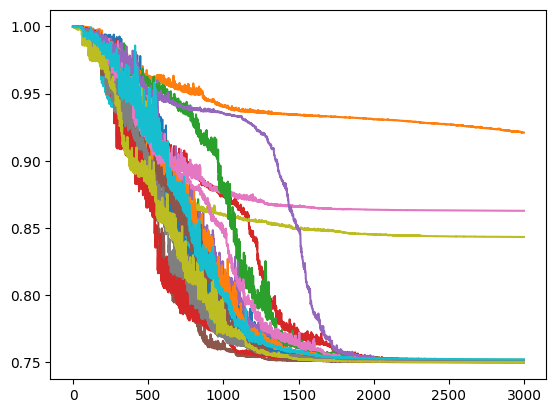

In [95]:
for l in scores[6]:
    plt.plot(l)

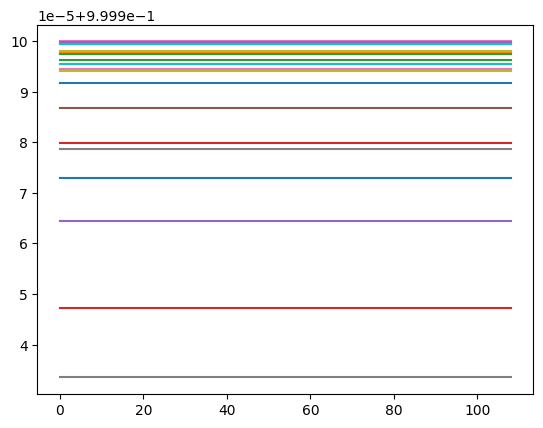

In [96]:
for l in scores[7]:
    plt.plot(l)

In [99]:
pd.Series([l[-1] for l in scores[6]]).describe()

count    20.000000
mean      0.769464
std       0.047587
min       0.749662
25%       0.750301
50%       0.750957
75%       0.751422
max       0.920920
dtype: float64

In [100]:
sorted([l[-1] for l in scores[6]])

[0.7496623992919922,
 0.7498911023139954,
 0.7498955726623535,
 0.7500014901161194,
 0.7502442598342896,
 0.7503203749656677,
 0.7506507039070129,
 0.7507585287094116,
 0.7508717179298401,
 0.7509250640869141,
 0.7509886026382446,
 0.7510458827018738,
 0.7511436939239502,
 0.7511648535728455,
 0.751316249370575,
 0.751738429069519,
 0.7519091367721558,
 0.8431562185287476,
 0.8626687526702881,
 0.9209204316139221]

So all but 3/20 are well optimized. Takes about 2000 iterations to converge.

# Gradient based methods

In [101]:
grad_based_methods = [
    #'Nelder-Mead',
    'L-BFGS-B',
    #'Powell',
    'CG',
    'BFGS',
    'Newton-CG',
    'TNC',
    #'COBYLA',
    'SLSQP',
    'trust-constr',
    'adam',
    'nadam',
    'rmsprop',
    'sgd',
    'cadam'
]

In [102]:
num_iterations=20

In [103]:
from collections import defaultdict

In [104]:
grad_scores = defaultdict(list)

In [105]:
for method in grad_based_methods:
    print(method)

    for i in range(num_iterations):
        print('-> ' + str(i))

        circ_pair = ansatz_circuit_pair(
            left_most_symmetry_site,
            num_symmetry_sites,
            num_boundary_sites,
            depth
        )
        
        tnopt = qtn.TNOptimizer(
            circ_pair,                        # the tensor network we want to optimize
            loss,                     # the function we want to minimize
            loss_constants={'problem_rdm': problem_rdm},  # supply U to the loss function as a constant TN
            tags=['U3'],              # only optimize U3 tensors
            #autodiff_backend='jax',   # use 'autograd' for non-compiled optimization
            optimizer=method,     # the optimization algorithm
            progbar=False
        )
        
        circ_opt = tnopt.optimize(
            n=2000,
            jac=True,
            hessp=False
        )

        grad_scores[method].append(tnopt.losses)

L-BFGS-B
-> 0


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/circuit.py:2587: FutureWarning: In future the tensor network returned by ``circ.uni`` will not be transposed as it is currently, to match the expectation from ``U = circ.uni.to_dense()`` behaving like ``U @ psi``. You can retain this behaviour with ``circ.get_uni(transposed=True)``.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(


-> 1
-> 2
-> 3
-> 4
-> 5
-> 6
-> 7
-> 8
-> 9
-> 10
-> 11
-> 12
-> 13
-> 14
-> 15
-> 16
-> 17
-> 18
-> 19
CG
-> 0


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/circuit.py:2587: FutureWarning: In future the tensor network returned by ``circ.uni`` will not be transposed as it is currently, to match the expectation from ``U = circ.uni.to_dense()`` behaving like ``U @ psi``. You can retain this behaviour with ``circ.get_uni(transposed=True)``.
  warnings.warn(


-> 1


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/circuit.py:2587: FutureWarning: In fu

-> 2


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/circuit.py:2587: FutureWarning: In fu

-> 3


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(


-> 4


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/circuit.py:2587: FutureWarning: In future the tensor network returned by ``circ.uni`` will not be transposed as it is currently, to match the expectation from ``U = circ.uni.to_dense()`` behaving like ``U @ psi``. You can retain this behaviour with ``circ.get_uni(transposed=True)``.
  warnings.warn(


-> 5


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/circuit.py:2587: FutureWarning: In fu

-> 6


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/circuit.py:2587: FutureWarning: In fu

-> 7


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(


-> 8


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/circuit.py:2587: FutureWarning: In future the tensor network returned by ``circ.uni`` will not be transposed as it is currently, to match the expectation from ``U = circ.uni.to_dense()`` behaving like ``U @ psi``. You can retain this behaviour with ``circ.get_uni(transposed=True)``.
  warnings.warn(


-> 9


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/circuit.py:2587: FutureWarning: In fu

-> 10


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(


-> 11


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/circuit.py:2587: FutureWarning: In future the tensor network returned by ``circ.uni`` will not be transposed as it is currently, to match the expectation from ``U = circ.uni.to_dense()`` behaving like ``U @ psi``. You can retain this behaviour with ``circ.get_uni(transposed=True)``.
  warnings.warn(


-> 12


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/circuit.py:2587: FutureWarning: In fu

-> 13


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/circuit.py:2587: FutureWarning: In fu

-> 14


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/circuit.py:2587: FutureWarning: In fu

-> 15


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/circuit.py:2587: FutureWarning: In fu

-> 16


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/circuit.py:2587: FutureWarning: In fu

-> 17


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype m

-> 18


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/circuit.py:2587: FutureWarning: In fu

-> 19


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/circuit.py:2587: FutureWarning: In fu

BFGS
-> 0


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/circuit.py:2587: FutureWarning: In fu

-> 1


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(


-> 2
-> 3
-> 4
-> 5
-> 6
-> 7
-> 8


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/circuit.py:2587: FutureWarning: In future the tensor network returned by ``circ.uni`` will not be transposed as it is currently, to match the expectation from ``U = circ.uni.to_dense()`` behaving like ``U @ psi``. You can retain this behaviour with ``circ.get_uni(transposed=True)``.
  warnings.warn(


-> 9


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(


-> 10


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/circuit.py:2587: FutureWarning: In future the tensor network returned by ``circ.uni`` will not be transposed as it is currently, to match the expectation from ``U = circ.uni.to_dense()`` behaving like ``U @ psi``. You can retain this behaviour with ``circ.get_uni(transposed=True)``.
  warnings.warn(


-> 11


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(


-> 12


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/circuit.py:2587: FutureWarning: In future the tensor network returned by ``circ.uni`` will not be transposed as it is currently, to match the expectation from ``U = circ.uni.to_dense()`` behaving like ``U @ psi``. You can retain this behaviour with ``circ.get_uni(transposed=True)``.
  warnings.warn(


-> 13


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(


-> 14
-> 15
-> 16


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/circuit.py:2587: FutureWarning: In future the tensor network returned by ``circ.uni`` will not be transposed as it is currently, to match the expectation from ``U = circ.uni.to_dense()`` behaving like ``U @ psi``. You can retain this behaviour with ``circ.get_uni(transposed=True)``.
  warnings.warn(


-> 17


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(


-> 18


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/circuit.py:2587: FutureWarning: In future the tensor network returned by ``circ.uni`` will not be transposed as it is currently, to match the expectation from ``U = circ.uni.to_dense()`` behaving like ``U @ psi``. You can retain this behaviour with ``circ.get_uni(transposed=True)``.
  warnings.warn(


-> 19


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(


Newton-CG
-> 0


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/circuit.py:2587: FutureWarning: In future the tensor network returned by ``circ.uni`` will not be transposed as it is currently, to match the expectation from ``U = circ.uni.to_dense()`` behaving like ``U @ psi``. You can retain this behaviour with ``circ.get_uni(transposed=True)``.
  warnings.warn(


-> 1


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/circuit.py:2587: FutureWarning: In fu

-> 2


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/circuit.py:2587: FutureWarning: In fu

-> 3


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/circuit.py:2587: FutureWarning: In fu

-> 4


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/circuit.py:2587: FutureWarning: In fu

-> 5


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/circuit.py:2587: FutureWarning: In fu

-> 6


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/circuit.py:2587: FutureWarning: In fu

-> 7


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/circuit.py:2587: FutureWarning: In fu

-> 8


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/circuit.py:2587: FutureWarning: In fu

-> 9


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/circuit.py:2587: FutureWarning: In fu

-> 10


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/circuit.py:2587: FutureWarning: In fu

-> 11


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/circuit.py:2587: FutureWarning: In fu

-> 12


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/circuit.py:2587: FutureWarning: In fu

-> 13


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/circuit.py:2587: FutureWarning: In fu

-> 14


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/circuit.py:2587: FutureWarning: In fu

-> 15


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/circuit.py:2587: FutureWarning: In fu

-> 16


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/circuit.py:2587: FutureWarning: In fu

-> 17


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/circuit.py:2587: FutureWarning: In fu

-> 18


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/circuit.py:2587: FutureWarning: In fu

-> 19


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/circuit.py:2587: FutureWarning: In fu

TNC
-> 0


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(


-> 1
-> 2
-> 3
-> 4
-> 5
-> 6
-> 7
-> 8
-> 9
-> 10
-> 11
-> 12
-> 13
-> 14
-> 15
-> 16
-> 17
-> 18
-> 19
SLSQP
-> 0
-> 1
-> 2
-> 3
-> 4
-> 5
-> 6
-> 7
-> 8
-> 9
-> 10
-> 11
-> 12
-> 13
-> 14
-> 15
-> 16
-> 17
-> 18
-> 19
trust-constr
-> 0


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


-> 1
-> 2
-> 3
-> 4
-> 5
-> 6
-> 7
-> 8
-> 9
-> 10
-> 11
-> 12
-> 13
-> 14
-> 15
-> 16
-> 17
-> 18
-> 19
adam
-> 0
-> 1
-> 2
-> 3
-> 4
-> 5
-> 6
-> 7
-> 8
-> 9
-> 10
-> 11
-> 12
-> 13
-> 14
-> 15
-> 16
-> 17
-> 18
-> 19
nadam
-> 0
-> 1
-> 2
-> 3
-> 4
-> 5
-> 6
-> 7
-> 8
-> 9
-> 10
-> 11
-> 12
-> 13
-> 14
-> 15
-> 16
-> 17
-> 18
-> 19
rmsprop
-> 0
-> 1
-> 2
-> 3
-> 4
-> 5
-> 6
-> 7
-> 8
-> 9
-> 10
-> 11
-> 12
-> 13
-> 14
-> 15
-> 16
-> 17
-> 18
-> 19
sgd
-> 0
-> 1
-> 2
-> 3
-> 4
-> 5
-> 6
-> 7
-> 8
-> 9
-> 10
-> 11
-> 12
-> 13
-> 14
-> 15
-> 16
-> 17
-> 18
-> 19
cadam
-> 0
-> 1
-> 2
-> 3
-> 4
-> 5
-> 6
-> 7
-> 8
-> 9
-> 10
-> 11
-> 12
-> 13
-> 14
-> 15
-> 16
-> 17
-> 18
-> 19


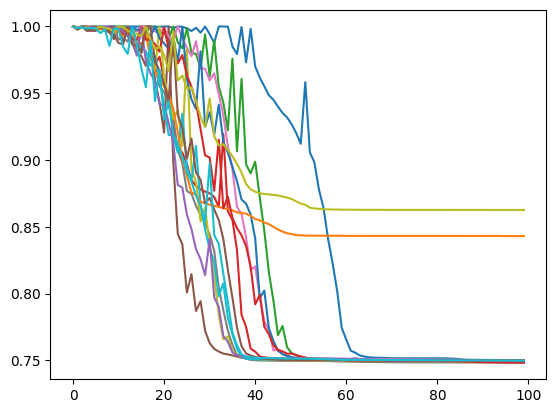

In [118]:
for l in grad_scores[grad_based_methods[0]]:
    plt.plot(l[:100])

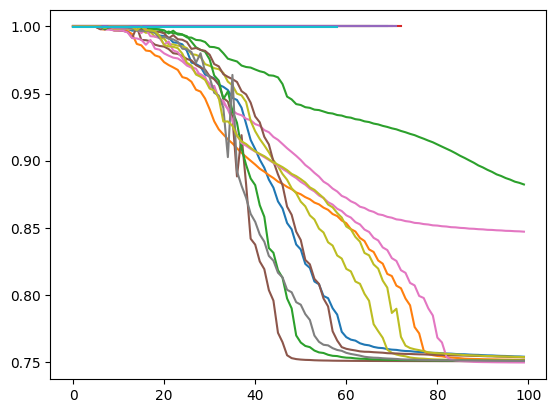

In [119]:
for l in grad_scores[grad_based_methods[1]]:
    plt.plot(l[:100])

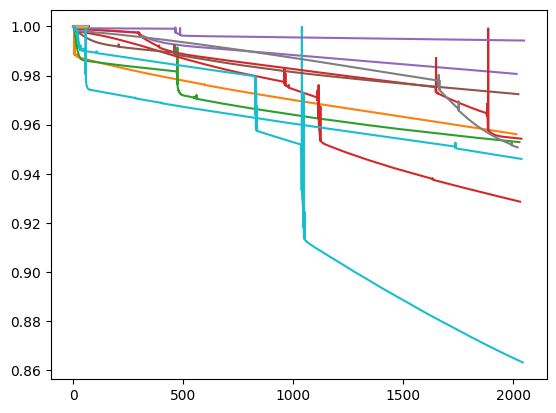

In [108]:
for l in grad_scores[grad_based_methods[2]]:
    plt.plot(l)

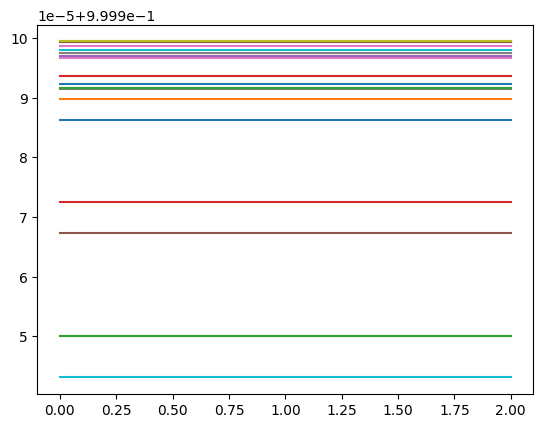

In [109]:
for l in grad_scores[grad_based_methods[3]]:
    plt.plot(l)

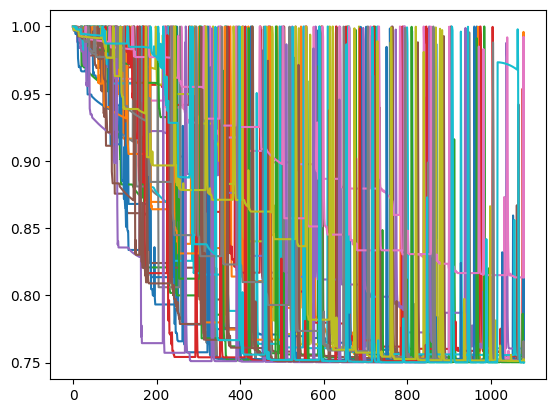

In [110]:
for l in grad_scores[grad_based_methods[4]]:
    plt.plot(l)

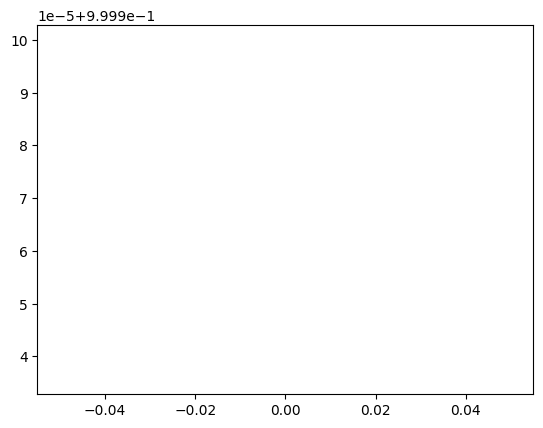

In [111]:
for l in grad_scores[grad_based_methods[5]]:
    plt.plot(l)

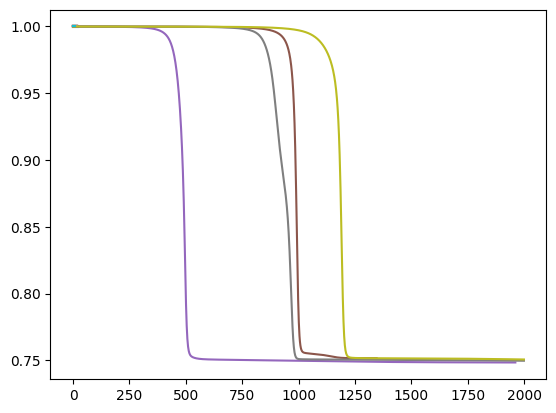

In [112]:
for l in grad_scores[grad_based_methods[6]]:
    plt.plot(l)

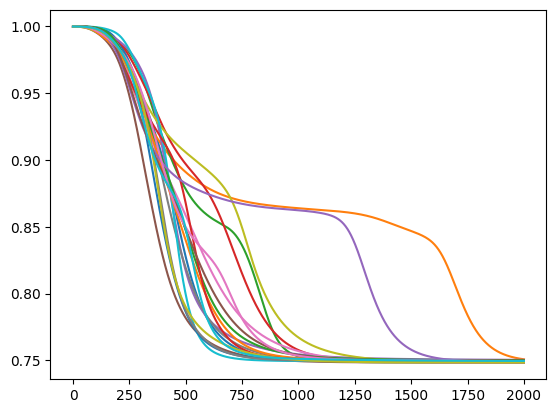

In [113]:
for l in grad_scores[grad_based_methods[7]]:
    plt.plot(l)

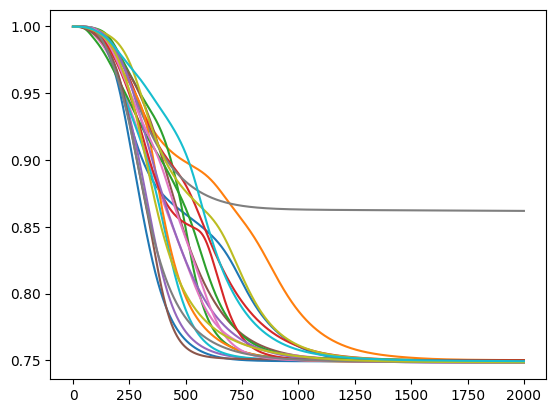

In [114]:
for l in grad_scores[grad_based_methods[8]]:
    plt.plot(l)

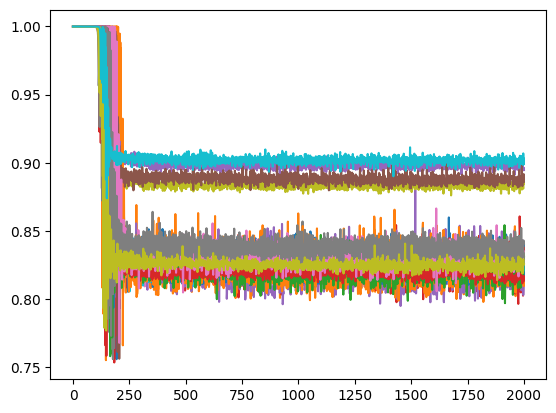

In [115]:
for l in grad_scores[grad_based_methods[9]]:
    plt.plot(l)

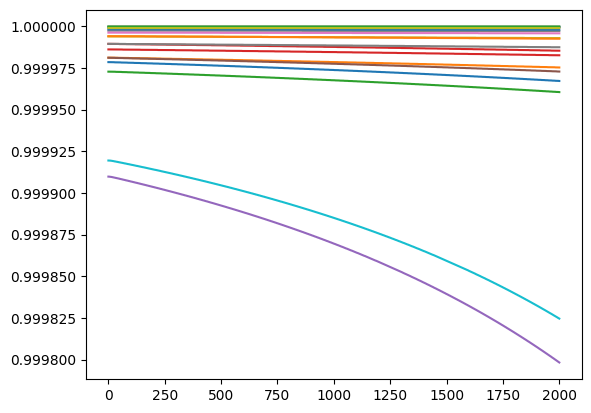

In [116]:
for l in grad_scores[grad_based_methods[10]]:
    plt.plot(l)

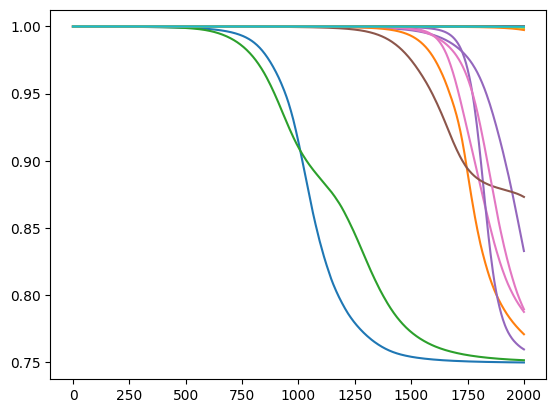

In [117]:
for l in grad_scores[grad_based_methods[11]]:
    plt.plot(l)

# Conclusions

It looks like Cobyla wins, again.